In [2]:
from glob import glob
from unidecode import unidecode
from dbfread import DBF
import os
import pandas as pd
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np # operações matemáticas
import seaborn as sns # visualização gráfica
import matplotlib.pyplot as plt # visualização gráfica
from scipy.interpolate import UnivariateSpline # curva sigmoide suavizada
import statsmodels.api as sm # estimação de modelos
import statsmodels.formula.api as smf # estimação do modelo logístico binário
from statstests.process import stepwise # procedimento Stepwise
from scipy import stats # estatística chi2
import plotly.graph_objects as go # gráficos 3D
from statsmodels.iolib.summary2 import summary_col # comparação entre modelos
from statsmodels.discrete.discrete_model import MNLogit # estimação do modelo
                                                        #logístico multinomial

from statsmodels.stats.diagnostic import het_white
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, roc_curve,\
                            precision_score, recall_score, roc_auc_score, balanced_accuracy_score
from sklearn.model_selection import GridSearchCV
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
import shap
import random
import tensorflow as tf
from tensorflow.keras import layers, models
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt

 REGRESSÃO LOGÍSTICA

 O modelo de regressão logística binária é baseado na função logística, que relaciona a probabilidade de ocorrência do evento (Pi) com as variáveis explicativas (Xi).
  A função logito (Zi) é definida como:

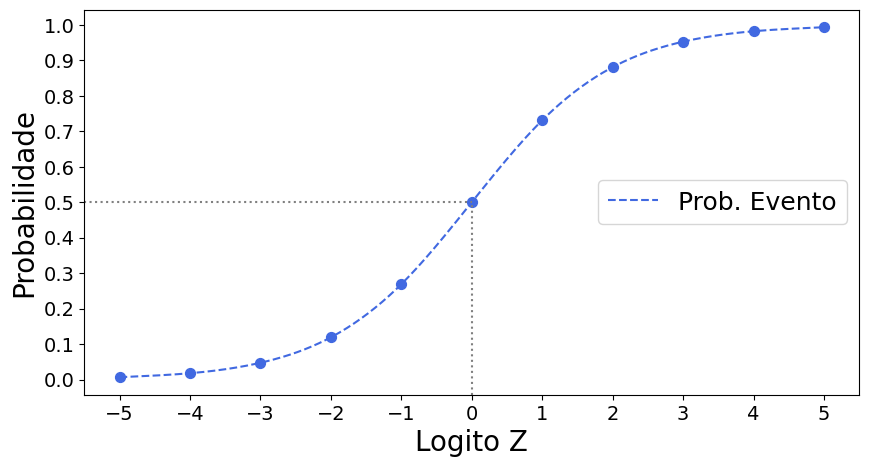

In [3]:

#############################################################################
#                             CURVA SIGMOIDE                                #
#############################################################################

# Estabelecendo uma função para a probabilidade de ocorrência de um evento

from math import exp

# Estabelecendo uma função para a probabilidade de ocorrência de um evento
def prob(z):
    return 1 / (1 + exp(-z))

# In[SIGMOIDE]: Plotando a curva sigmoide teórica de ocorrência de um evento
#para um range do logito z entre -5 e +5

logitos = []
probs = []

for i in np.arange(-5, 6):
    logitos.append(i)
    probs.append(prob(i))
    
df = pd.DataFrame({'logito': logitos, 'probs': probs})

# Interpolação spline (smooth probability line)
spline = UnivariateSpline(df['logito'], df['probs'], s=0)

logitos_smooth = np.linspace(df['logito'].min(), df['logito'].max(), 500)
probs_smooth = spline(logitos_smooth)

plt.figure(figsize=(10,5))
plt.plot(logitos_smooth, probs_smooth, color='royalblue',
         linestyle='--', label='Prob. Evento')
plt.scatter(df['logito'], df['probs'], color='royalblue', marker='o', s=50)
plt.axhline(y = df.probs.mean(), color = 'grey', linestyle = ':', xmax = .5)
plt.axvline(x = 0, color = 'grey', linestyle=':', ymax = 0.5)
plt.xlabel("Logito Z", fontsize=20)
plt.ylabel("Probabilidade", fontsize=20)
plt.xticks(np.arange(-5, 6), fontsize=14)
plt.yticks(np.arange(0, 1.1, 0.1), fontsize=14)
plt.legend(fontsize=18, loc='center right')
plt.show()

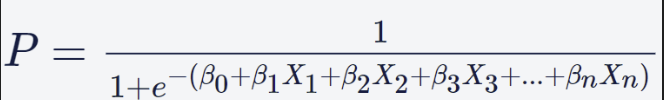

In [4]:
df_sivep_dummies = pd.read_excel('df_sivep_dummies.xlsx')

In [ ]:
for i in df_sivep_dummies.columns:
    if i == 'IDADE_AJUS':
        pass
    else:
        print(df_sivep_dummies[i].value_counts(dropna= False))
        print(30*'-')

EVOLUCAO
0    5330
1    1813
Name: count, dtype: int64
------------------------------
CS_RACA_BRANCA_SIM
0    6326
1     817
Name: count, dtype: int64
------------------------------
DIARREIA_SIM
0    6642
1     501
Name: count, dtype: int64
------------------------------
NOSOCOMIAL_SIM
0    6841
1     302
Name: count, dtype: int64
------------------------------
TOSSE_SIM
1    5413
0    1730
Name: count, dtype: int64
------------------------------
DESC_RESP_SIM
1    4924
0    2219
Name: count, dtype: int64
------------------------------
UTI_SIM
0    4462
1    2681
Name: count, dtype: int64
------------------------------
SUPORT_VEN_INVASIVO
0    5701
1    1442
Name: count, dtype: int64
------------------------------
SUPORT_VEN_NAO_INVASIVO
0    4110
1    3033
Name: count, dtype: int64
------------------------------
CLASSI_FIN_SRAG_OUTRO_AGENTE_ETIOLOGICO
0    7088
1      55
Name: count, dtype: int64
------------------------------
FATOR_RISC_SIM
1    4381
0    2762
Name: count, dtype: int

<Axes: >

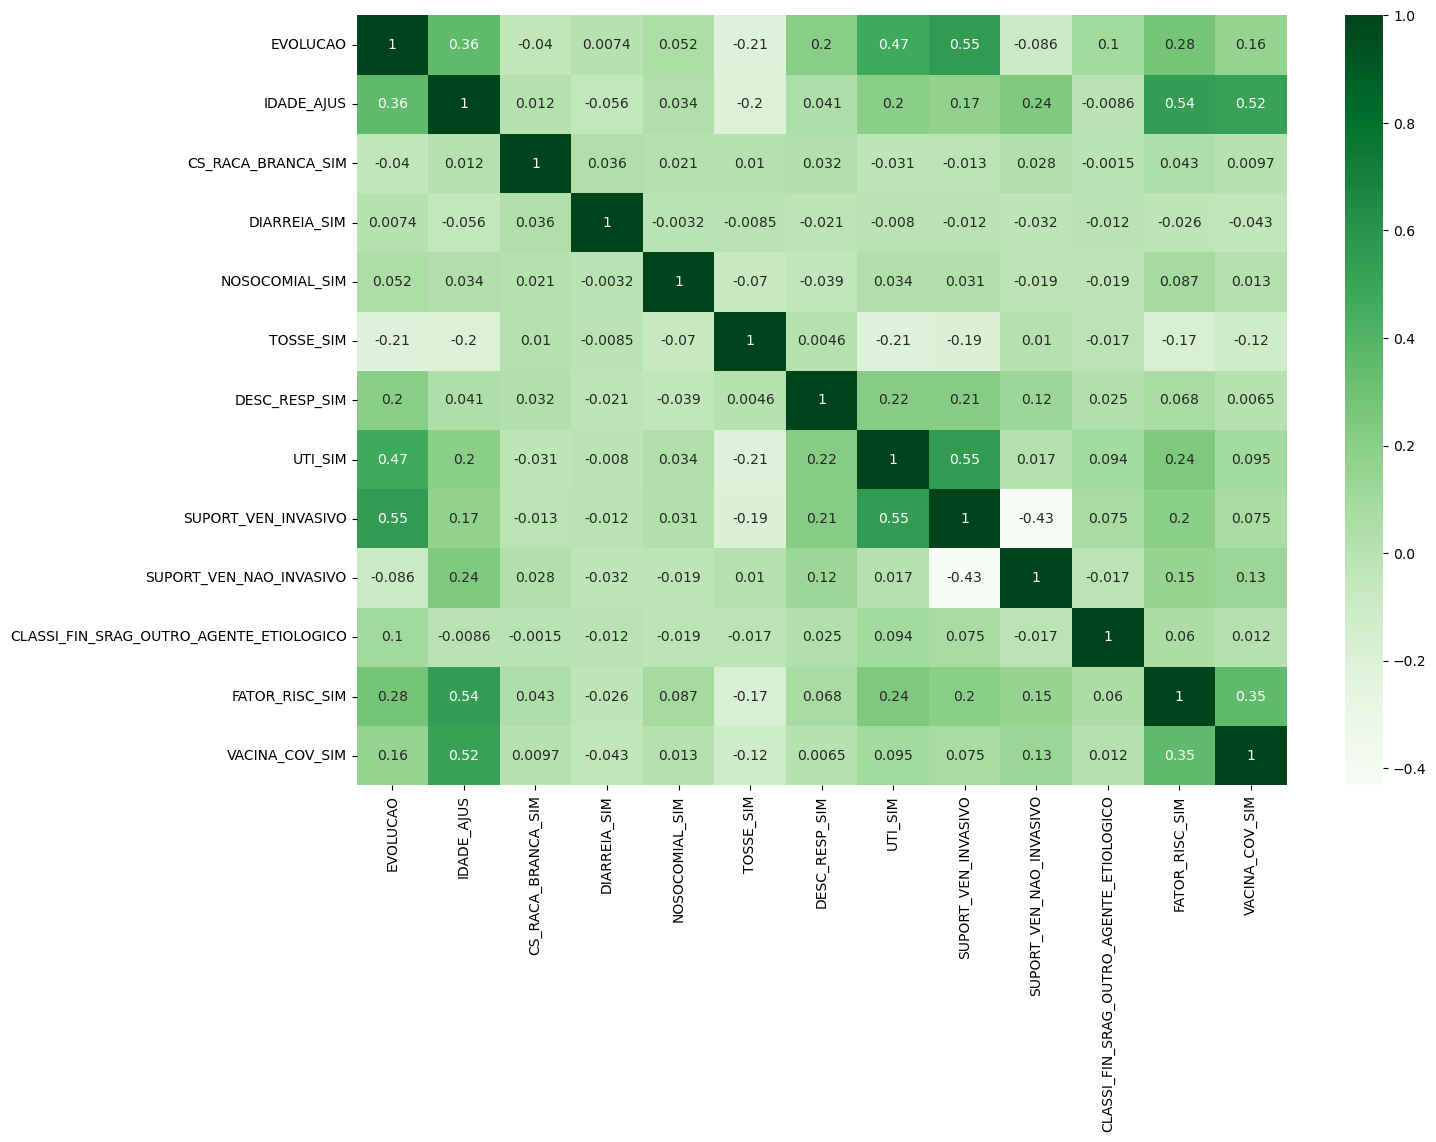

In [26]:
#MATRIZ DE CORRELAÇÃO

plt.figure(figsize=(15, 10))
sns.heatmap(df_sivep_dummies.corr(), annot=True, cmap='Greens')

In [27]:
# Estimação do modelo logístico binário

lista_colunas = list(df_sivep_dummies.drop(columns=['EVOLUCAO']).columns)
formula_dummies_modelo = ' + '.join(lista_colunas)
formula_dummies_modelo = "EVOLUCAO ~ " + formula_dummies_modelo
print("Fórmula utilizada: ",formula_dummies_modelo)

Fórmula utilizada:  EVOLUCAO ~ IDADE_AJUS + CS_RACA_BRANCA_SIM + DIARREIA_SIM + NOSOCOMIAL_SIM + TOSSE_SIM + DESC_RESP_SIM + UTI_SIM + SUPORT_VEN_INVASIVO + SUPORT_VEN_NAO_INVASIVO + CLASSI_FIN_SRAG_OUTRO_AGENTE_ETIOLOGICO + FATOR_RISC_SIM + VACINA_COV_SIM


In [28]:
# Modelo
modelo = sm.Logit.from_formula(formula_dummies_modelo,
                                               df_sivep_dummies).fit(cov_type='HC0')

# # Parâmetros do modelo
modelo.summary()

Optimization terminated successfully.
         Current function value: 0.334843
         Iterations 8


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:               EVOLUCAO   No. Observations:                 7143
Model:                          Logit   Df Residuals:                     7130
Method:                           MLE   Df Model:                           12
Date:                Sat, 05 Apr 2025   Pseudo R-squ.:                  0.4089
Time:                        20:02:31   Log-Likelihood:                -2391.8
converged:                       True   LL-Null:                       -4046.4
Covariance Type:                  HC0   LLR p-value:                     0.000
===========================================================================================================
                                              coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------------
Intercept                                  -4.9152      0.160    -30.656      0.000      -5.229      -4.601
IDADE_AJUS                                  0.0315      0.002     19.799      0.000       0.028       0.035
CS_RACA_BRANCA_SIM                         -0.4581      0.126     -3.646      0.000      -0.704      -0.212
DIARREIA_SIM                                0.4929      0.130      3.790      0.000       0.238       0.748
NOSOCOMIAL_SIM                              0.6228      0.170      3.653      0.000       0.289       0.957
TOSSE_SIM                                  -0.4022      0.080     -5.000      0.000      -0.560      -0.245
DESC_RESP_SIM                               0.5676      0.091      6.222      0.000       0.389       0.746
UTI_SIM                                     1.2039      0.085     14.177      0.000       1.037       1.370
SUPORT_VEN_INVASIVO                         2.6350      0.134     19.668      0.000       2.372       2.898
SUPORT_VEN_NAO_INVASIVO                     0.6366      0.114      5.605      0.000       0.414       0.859
CLASSI_FIN_SRAG_OUTRO_AGENTE_ETIOLOGICO     1.8717      0.458      4.089      0.000       0.975       2.769
FATOR_RISC_SIM                              0.5298      0.096      5.496      0.000       0.341       0.719
VACINA_COV_SIM                             -0.2315      0.095     -2.435      0.015      -0.418      -0.045
===========================================================================================================
"""

In [29]:
#Procedimento Stepwise

#Estimação do modelo por meio do procedimento Stepwise
step_modelo = stepwise(modelo, pvalue_limit=0.05)

Regression type: Logit 

Estimating model...: 
 EVOLUCAO ~ Q('IDADE_AJUS') + Q('CS_RACA_BRANCA_SIM') + Q('DIARREIA_SIM') + Q('NOSOCOMIAL_SIM') + Q('TOSSE_SIM') + Q('DESC_RESP_SIM') + Q('UTI_SIM') + Q('SUPORT_VEN_INVASIVO') + Q('SUPORT_VEN_NAO_INVASIVO') + Q('CLASSI_FIN_SRAG_OUTRO_AGENTE_ETIOLOGICO') + Q('FATOR_RISC_SIM') + Q('VACINA_COV_SIM')
Optimization terminated successfully.
         Current function value: 0.334843
         Iterations 8

 No more atributes with p-value higher than 0.05

 Atributes discarded on the process...: 


 Model after stepwise process...: 
 EVOLUCAO ~ Q('IDADE_AJUS') + Q('CS_RACA_BRANCA_SIM') + Q('DIARREIA_SIM') + Q('NOSOCOMIAL_SIM') + Q('TOSSE_SIM') + Q('DESC_RESP_SIM') + Q('UTI_SIM') + Q('SUPORT_VEN_INVASIVO') + Q('SUPORT_VEN_NAO_INVASIVO') + Q('CLASSI_FIN_SRAG_OUTRO_AGENTE_ETIOLOGICO') + Q('FATOR_RISC_SIM') + Q('VACINA_COV_SIM') 

                           Logit Regression Results                           
Dep. Variable:               EVOLUCAO   No. O

In [30]:
#cálculo das chances

betas = step_modelo.params

# Convertendo os betas em um DataFrame
betas_df = pd.DataFrame(betas, columns=['Betas']).reset_index()

# calculando a chance do beta  

#a cada grau (em média) que aumenta a chance de ocorrência de falha é multiplicada por 0,69
#ou seja é 31% menor

odds = []

for i in betas_df['Betas']:
    if i >= 0:
        odds.append(f"fm óbito {round(np.exp(i), 2)}")
    else:
        odds.append(f"fm não óbito {round(np.exp(i), 2)}, a chance {round((np.exp(i) -1)*100, 2)}% menor")

betas_df['odds'] = odds

betas_df.to_excel('betas.xlsx', index= False)

# Exibindo o DataFrame
display(betas_df[1:])

,index,Betas,odds
1,Q('IDADE_AJUS'),0.031463,fm óbito 1.03
2,Q('CS_RACA_BRANCA_SIM'),-0.458140,"fm não óbito 0.63, a chance -36.75% menor"
3,Q('DIARREIA_SIM'),0.492910,fm óbito 1.64
4,Q('NOSOCOMIAL_SIM'),0.622801,fm óbito 1.86
5,Q('TOSSE_SIM'),-0.402202,"fm não óbito 0.67, a chance -33.12% menor"
6,Q('DESC_RESP_SIM'),0.567571,fm óbito 1.76
7,Q('UTI_SIM'),1.203857,fm óbito 3.33
8,Q('SUPORT_VEN_INVASIVO'),2.634953,fm óbito 13.94
9,Q('SUPORT_VEN_NAO_INVASIVO'),0.636563,fm óbito 1.89
10,Q('CLASSI_FIN_SRAG_OUTRO_AGENTE_ETIOLOGICO'),1.871726,fm óbito 6.5


In [31]:
df_sivep_dummies.to_excel('df_sivep_dummies.xlsx', index = False)

# Adicionando os valores previstos de probabilidade na base de dados

df_sivep_dummies['phat'] = step_modelo.predict()

df_sivep_dummies

,EVOLUCAO,IDADE_AJUS,CS_RACA_BRANCA_SIM,DIARREIA_SIM,NOSOCOMIAL_SIM,TOSSE_SIM,DESC_RESP_SIM,UTI_SIM,SUPORT_VEN_INVASIVO,SUPORT_VEN_NAO_INVASIVO,CLASSI_FIN_SRAG_OUTRO_AGENTE_ETIOLOGICO,FATOR_RISC_SIM,VACINA_COV_SIM,phat
0,1,66,0,0,0,1,1,1,1,0,0,1,1,0.812104
1,1,97,0,0,0,1,1,0,0,1,0,0,1,0.215357
2,1,89,1,0,0,0,1,1,1,0,0,1,1,0.893921
3,1,79,0,0,0,0,1,1,1,0,0,0,0,0.878330
4,0,80,0,0,0,0,0,0,0,1,0,1,1,0.187947
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15979,0,96,1,0,0,1,0,1,0,0,0,1,1,0.222172
15981,0,79,1,0,0,1,0,1,0,0,0,1,1,0.143328
15983,0,74,1,0,0,1,0,0,0,0,0,1,1,0.041127
15987,1,68,0,0,0,0,1,0,0,1,0,1,1,0.218679


In [32]:
#Teste de Breusch-Pagan

import statsmodels.api as sm
from scipy import stats

# Função para o teste de Breusch-Pagan
def breusch_pagan_test(modelo):

    # Criação do dataframe com os valores ajustados e resíduos
    df = pd.DataFrame({'phat': modelo.fittedvalues,
                       'resid': modelo.resid_pearson})
    
    # Cálculo da variância dos resíduos ajustados
    df['up'] = np.square(df.resid) / np.sum(np.square(df.resid)) * df.shape[0]
    
    # Modelo auxiliar de regressão linear para os resíduos
    modelo_aux = sm.OLS.from_formula("up ~ phat", df).fit()
    
    # Obtenção da estatística do teste (soma dos quadrados explicada)
    anova_table = sm.stats.anova_lm(modelo_aux, typ=2)
    
    # Soma dos quadrados (chi-square estatística)
    chisq = anova_table['sum_sq'].iloc[0]
    
    # Cálculo do p-value usando a distribuição chi-squared
    p_value = stats.chi2.sf(chisq, 1)
    
    # Exibição dos resultados
    print(f"Chi-squared: {chisq}")
    print(f"P-value: {p_value}")
    
    return chisq, p_value

#######################################################

# Aplicando a função criada para realizar o teste no modelo ajustado

teste_bp = breusch_pagan_test(step_modelo)

# Tomando a decisão por meio do teste de hipóteses
alpha = 0.05 # nível de significância do teste

if teste_bp[1] > alpha:
    print('Não se rejeita H0 - Ausência de Heterocedasticidade (teste de Breusch-Pagan)')
else:
    print('Rejeita-se H0 - Existência de Heterocedasticidade (teste de Breusch-Pagan)')

Chi-squared: 918.1534339146259
P-value: 1.1105183974539296e-201
Rejeita-se H0 - Existência de Heterocedasticidade (teste de Breusch-Pagan)


In [33]:
# Teste de White

import statsmodels.api as sm
from statsmodels.stats.diagnostic import het_white

# Ajustar o modelo logit
modelo = sm.Logit.from_formula(formula_dummies_modelo, df_sivep_dummies).fit()

# Realizar o Teste de White
white_test = het_white(modelo.resid_pearson, modelo.model.exog)

# Test Statistic p-value
p_value_white = white_test[1]  # P-value da estatística do teste

# Tomando a decisão por meio do teste de hipóteses
alpha = 0.05  # nível de significância do teste

print('p_value_white:', p_value_white)

if p_value_white > alpha:
    print('Não se rejeita H0 - Ausência de Heterocedasticidade (Teste de White)')
else:
    print('Rejeita-se H0 - Existência de Heterocedasticidade (Teste de White)')

Optimization terminated successfully.
         Current function value: 0.334843
         Iterations 8
p_value_white: 7.508242363035698e-06
Rejeita-se H0 - Existência de Heterocedasticidade (Teste de White)


In [34]:
def avalia_modelo (predicts, observado, cutoff = 0.5, rótulos_y=['Não óbito', 'Óbito']):
    
    #values = predicts.values
    
    predicao_binaria = []
        
    for item in predicts:
        if item < cutoff:
            predicao_binaria.append(0)
        else:
            predicao_binaria.append(1)
           
    cm = confusion_matrix(y_true = observado, y_pred = predicao_binaria)   
    vn, fp, fn, vp = cm.ravel()
    ac = accuracy_score(y_true = observado, y_pred = predicao_binaria)
    bac = balanced_accuracy_score(y_true = observado, y_pred = predicao_binaria)
    precisao = precision_score(y_true = observado, y_pred = predicao_binaria)
    recall = recall_score(y_true = observado, y_pred = predicao_binaria)
    f1 = f1_score(y_true = observado, y_pred = predicao_binaria)
    especificidade = vn / (vn + fp) 

    sns.heatmap(cm, 
                annot=True, fmt='d', cmap='viridis', 
                xticklabels=rótulos_y, 
                yticklabels=rótulos_y)
    
    # Calculando AUC
    auc_score = roc_auc_score(y_true = observado, y_score = predicts)
    
    # Gerar a Curva ROC
    fpr, tpr, thresholds = roc_curve(y_true = observado, y_score = predicts)

    # Plotar a Curva ROC
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='blue', label=f'Curva ROC (AUC = {auc_score:.2%})')
    plt.plot([0, 1], [0, 1], color='red', linestyle='--')  # Linha de referência (modelo aleatório)
    plt.xlabel("Taxa de Falsos Positivos (FPR)")
    plt.ylabel("Taxa de Verdadeiros Positivos (TPR)")
    plt.title(f"Curva ROC")
    plt.legend(loc="lower right")
    plt.grid()
    plt.show()

    data = {    
    "Modelos": ["Logit"],
    "Acuracia": [ac],
    "Acuracia Balanceada": [bac],
    "Precisão": [precisao],
    "Recall": [recall],
    "Especificidade": [especificidade],
    "F1-Score": [f1],
    "AUC": [auc_score]
    }
    df_metrics = pd.DataFrame(data)

    display(df_metrics)

    return df_metrics

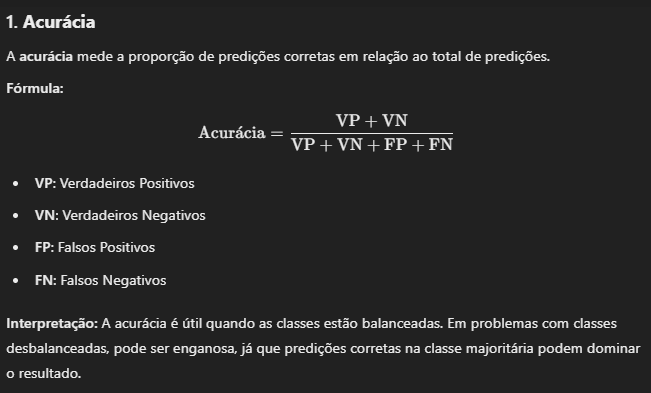
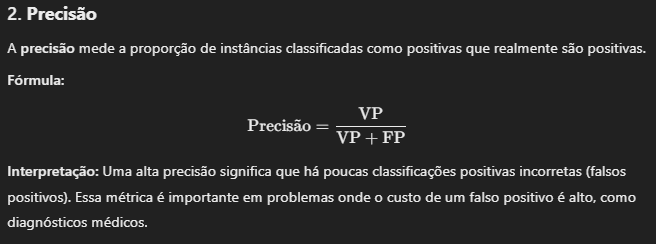
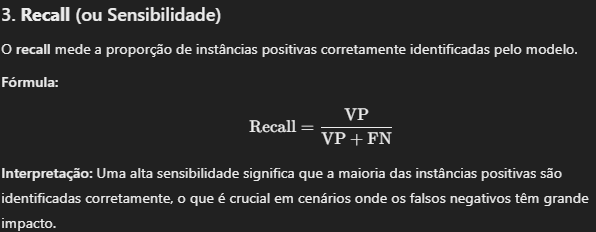
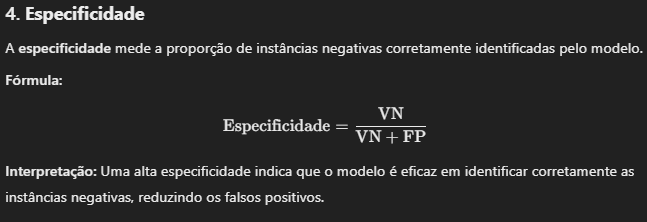
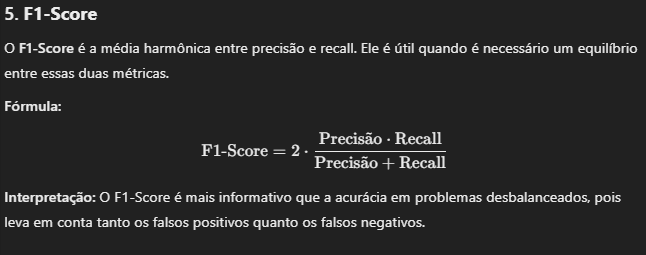
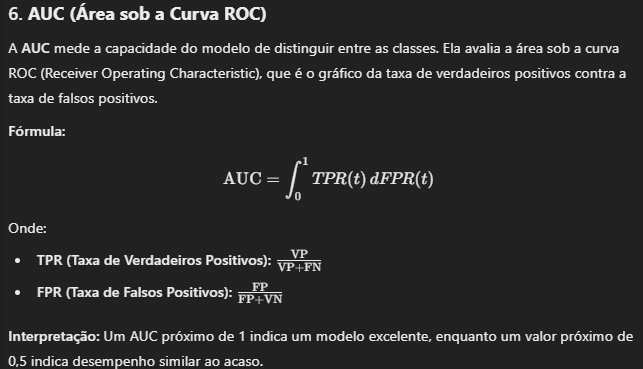
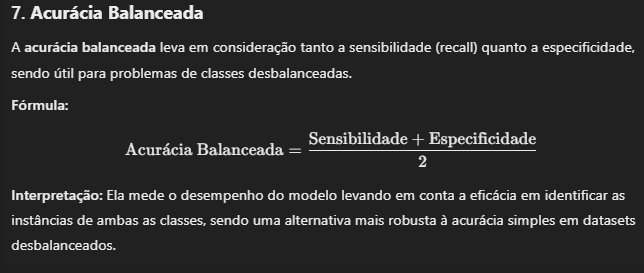

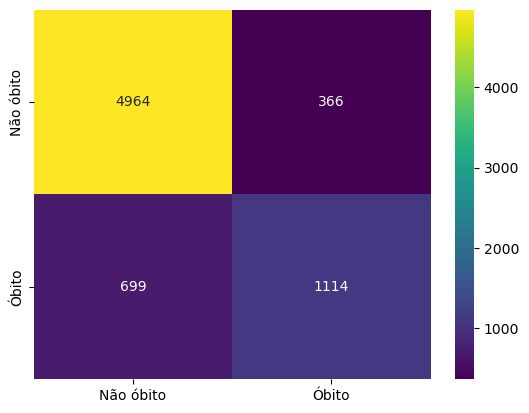

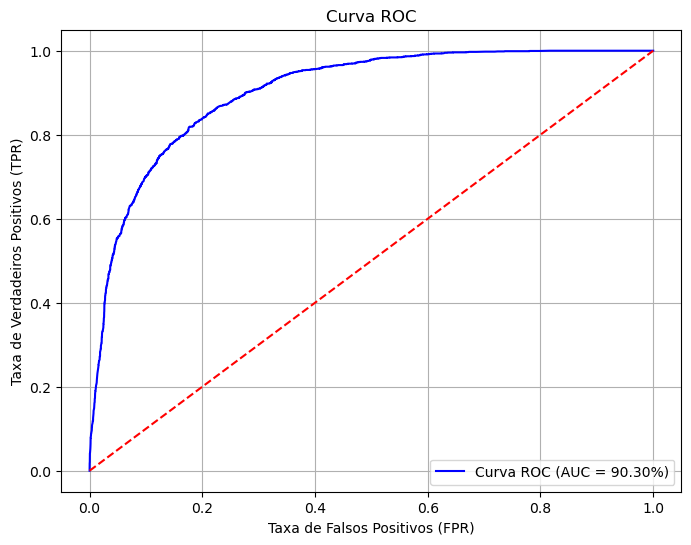

,Modelos,Acuracia,Acuracia Balanceada,Precisão,Recall,Especificidade,F1-Score,AUC
0,Logit,0.850903,0.772892,0.752703,0.614451,0.931332,0.676587,0.903017


In [35]:
df_resultado_logit = avalia_modelo(df_sivep_dummies['phat'], df_sivep_dummies['EVOLUCAO'])

In [36]:
#DIVISÃO EM TREINO E TESTE

y = df_sivep_dummies['EVOLUCAO']

X = df_sivep_dummies.drop(columns = ['EVOLUCAO', 'phat'])

X_treino, X_teste, y_treino, y_teste = train_test_split(X, y, test_size = 0.2, random_state = 42)

print('Nº linhas e colunas na base do X_treino:', X_treino.shape)
print(50*'-')

print('Nº linhas e colunas na base do y_treino:', y_treino.shape)
print(50*'-')

print('Nº linhas e colunas na base do X_teste:', X_teste.shape)
print(50*'-')

print('Nº linhas e colunas na base do y_teste:', y_teste.shape)
print(50*'-')

Nº linhas e colunas na base do X_treino: (5714, 12)
--------------------------------------------------
Nº linhas e colunas na base do y_treino: (5714,)
--------------------------------------------------
Nº linhas e colunas na base do X_teste: (1429, 12)
--------------------------------------------------
Nº linhas e colunas na base do y_teste: (1429,)
--------------------------------------------------


In [37]:
# FUNÇÃO MÉTRICAS BASE DE TREINO E BASE DE TESTE

def avalia_treino_teste(clf, X_tr, X_te, y_tr, y_te, rótulos_y=['Não óbito', 'Óbito',]):
    
    # Calcular as classificações preditas
    pred_tr = clf.predict(X_tr)
    
    # Calcular a probabilidade de evento
    y_prob_tr = clf.predict_proba(X_tr)[:, -1]
    
    # Calculando acurácia e matriz de confusão
    cm_tr = confusion_matrix(y_tr, pred_tr)
    vn_tr, fp_tr, fn_tr, vp_tr = cm_tr.ravel()
    ac_tr = accuracy_score(y_tr, pred_tr)
    bac_tr = balanced_accuracy_score(y_tr, pred_tr) 
    precisao_tr = precision_score(y_tr, pred_tr)
    recall_tr = recall_score(y_tr, pred_tr)
    f1_tr = f1_score(y_tr, pred_tr)
    especificidade_tr = vn_tr / (vn_tr + fp_tr)
    
    # Calculando AUC
    auc_score_tr = roc_auc_score(y_tr, y_prob_tr)    
    
    # Visualização gráfica

    print("BASE TREINO")  
    
    sns.heatmap(cm_tr, 
                annot=True, fmt='d', cmap='viridis', 
                xticklabels=rótulos_y, 
                yticklabels=rótulos_y)    
    
    # Gerar a Curva ROC
    fpr_tr, tpr_tr, thresholds_tr = roc_curve(y_tr, y_prob_tr)
    
    #Plotar a Curva ROC
    plt.figure(figsize=(8, 6))
    plt.plot(fpr_tr, tpr_tr, color='blue', label=f'Curva ROC (AUC = {auc_score_tr:.2%})')
    plt.plot([0, 1], [0, 1], color='red', linestyle='--')  # Linha de referência (modelo aleatório)
    plt.xlabel("Taxa de Falsos Positivos (FPR)")
    plt.ylabel("Taxa de Verdadeiros Positivos (TPR)")
    plt.title(f"Curva ROC - base de treino")
    plt.legend(loc="lower right")
    plt.grid()
    plt.show()

    print(60*"*")    

    ##################################################################

    # Calcular as classificações preditas
    pred_te = clf.predict(X_te)
    
    # Calcular a probabilidade de evento
    y_prob_te = clf.predict_proba(X_te)[:, -1]
    
    # Calculando acurácia e matriz de confusão
    cm_te = confusion_matrix(y_te, pred_te)
    vn_te, fp_te, fn_te, vp_te = cm_te.ravel()
    ac_te = accuracy_score(y_te, pred_te)
    bac_te = balanced_accuracy_score(y_te, pred_te)
    precisao_te = precision_score(y_te, pred_te)
    recall_te = recall_score(y_te, pred_te)
    f1_te = f1_score(y_te, pred_te)
    especificidade_te = vn_te / (vn_te + fp_te)
    
    # Calculando AUC
    auc_score_te = roc_auc_score(y_te, y_prob_te)
    
    # Visualização gráfica

    print("BASE TESTE")      

    sns.heatmap(cm_te, 
                annot=True, fmt='d', cmap='viridis', 
                xticklabels=rótulos_y, 
                yticklabels=rótulos_y)    
    
    # Gerar a Curva ROC
    fpr_te, tpr_te, thresholds_te = roc_curve(y_te, y_prob_te)
    
    # Plotar a Curva ROC
    plt.figure(figsize=(8, 6))
    plt.plot(fpr_te, tpr_te, color='blue', label=f'Curva ROC (AUC = {auc_score_te:.2%})')
    plt.plot([0, 1], [0, 1], color='red', linestyle='--')  # Linha de referência (modelo aleatório)
    plt.xlabel("Taxa de Falsos Positivos (FPR)")
    plt.ylabel("Taxa de Verdadeiros Positivos (TPR)")
    plt.title(f"Curva ROC - base de teste")
    plt.legend(loc="lower right")
    plt.grid()
    plt.show()
    print(60*"*")

    clf_class = clf.__class__.__name__    

    data = {
    f"{clf_class}": ["Base de treino", "Base de teste"],
    "Acuracia": [ac_tr, ac_te],
    "Acuracia Balanceada": [bac_tr, bac_te],
    "Precisão": [precisao_tr, precisao_te],
    "Recall": [recall_tr, recall_te],
    "Especificidade": [especificidade_tr, especificidade_te],
    "F1-Score": [f1_tr, f1_te],
    "AUC": [auc_score_tr, auc_score_te]
    }
    df_tr_te = pd.DataFrame(data)
    display(df_tr_te)

Decision Tree Classifier

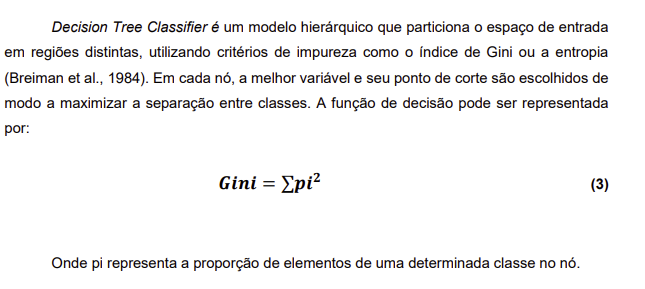

In [38]:
modelo_ajustado_dtc = DecisionTreeClassifier()

# Define os hiperparâmetros para o DecisionTreeClassifier
param_grid_dtc = {
    'criterion': ['gini', 'entropy'],  # Funções de critério
    'max_depth': [2, 4, 6, 8, 10, None],  # Profundidade máxima da árvore
    'min_samples_split': [2, 4, 6, 8],  # Mínimo de amostras para divisão (o nó sera divido para baixo nesses limites)
    'min_samples_leaf': [1, 2, 3, 4],  # Mínimo de amostras em uma folha (quantidade de amostras por folha)
    'max_features': [None, 'sqrt', 'log2'],  # Máximo de features consideradas
    'random_state': [42]  # Semente para reprodução
}

# Cria um objeto GridSearchCV
grid_search_dtc = GridSearchCV(
    modelo_ajustado_dtc, 
    param_grid=param_grid_dtc, 
    cv=5, 
    scoring='roc_auc',
    verbose=1,
    n_jobs=-1
).fit(X_treino, y_treino.values.ravel())

# Exibe os melhores hiperparâmetros encontrados
print("Melhores parâmetros:", grid_search_dtc.best_params_)

# Extrai o melhor modelo
melhor_modelo_dtc = grid_search_dtc.best_estimator_

Fitting 5 folds for each of 576 candidates, totalling 2880 fits
Melhores parâmetros: {'criterion': 'entropy', 'max_depth': 6, 'max_features': None, 'min_samples_leaf': 4, 'min_samples_split': 2, 'random_state': 42}


BASE TREINO


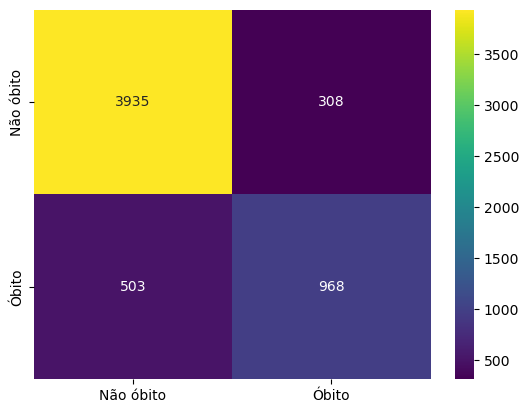

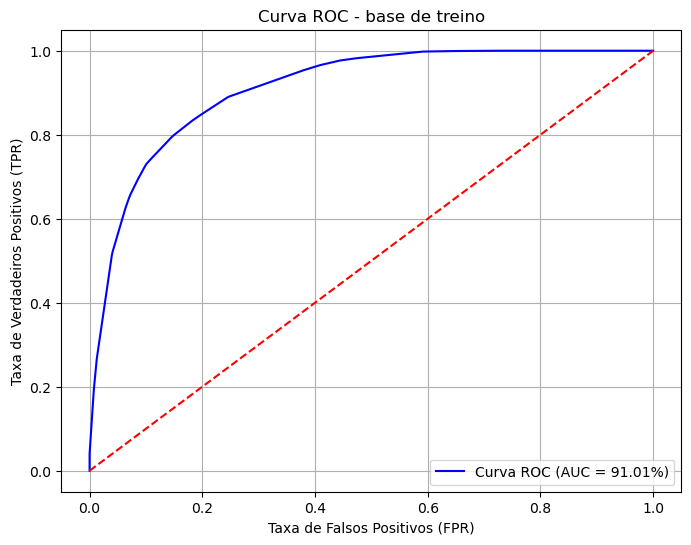

************************************************************
BASE TESTE


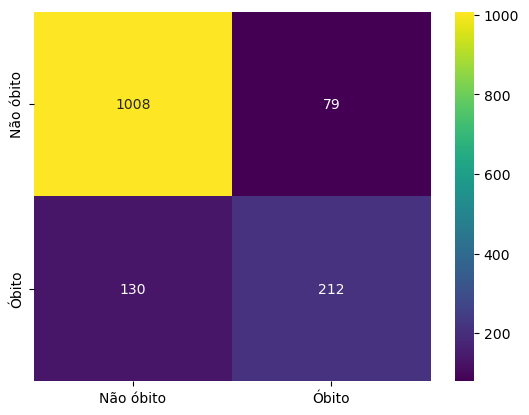

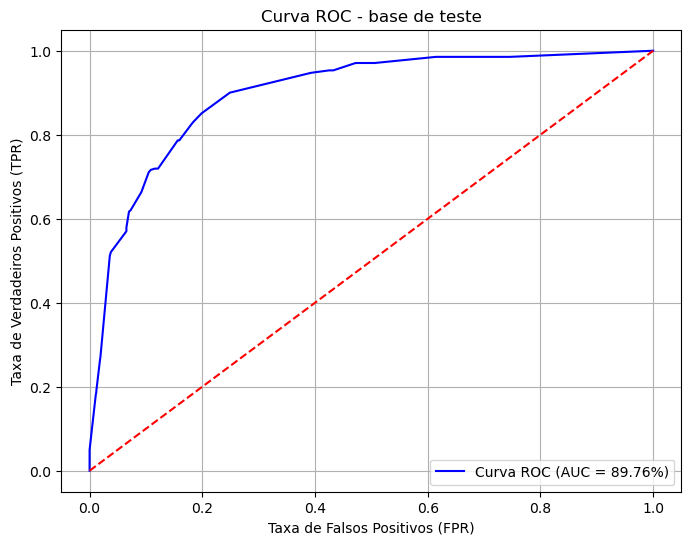

************************************************************


,DecisionTreeClassifier,Acuracia,Acuracia Balanceada,Precisão,Recall,Especificidade,F1-Score,AUC
0,Base de treino,0.858068,0.792733,0.758621,0.658056,0.927410,0.704769,0.910062
1,Base de teste,0.853744,0.773603,0.728522,0.619883,0.927323,0.669826,0.897639


In [39]:
avalia_treino_teste(melhor_modelo_dtc, X_treino, X_teste, y_treino, y_teste)

Random Forest Classifier

Random Forest são um conjunto de classificadores baseados em árvores de decisão, onde cada árvore é construída a partir de subconjuntos aleatórios de dados e variáveis explicativas. A predição final é feita por média das predições (para regressão) ou votação majoritária (para classificação). Esse método melhora a robustez do modelo e reduz o risco de sobreajuste ao evitar alta correlação entre as árvores (Breiman, 2001).

In [40]:
modelo_ajustado_rfc = RandomForestClassifier()

#define hyperparameters 

param_grid_rfc = {
    'n_estimators': [50, 100, 200],
    'max_depth': [2, 4, 6, 8, 10],
    'min_samples_split': [2, 4, 6, 8],
    'min_samples_leaf': [1, 2, 3, 4],
    'max_features': ['sqrt', 'log2'],
    'random_state': [42]
}

#Create a GridSearchCV object

grid_search_rfc = GridSearchCV(
    modelo_ajustado_rfc, 
    param_grid = param_grid_rfc,
    cv = 5,
    scoring = 'roc_auc',
    verbose=1,
    n_jobs=-1).fit(X_treino, y_treino.values.ravel())

print(grid_search_rfc.best_params_)

melhor_modelo_rfc = grid_search_rfc.best_estimator_

Fitting 5 folds for each of 480 candidates, totalling 2400 fits
{'max_depth': 8, 'max_features': 'sqrt', 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 200, 'random_state': 42}


BASE TREINO


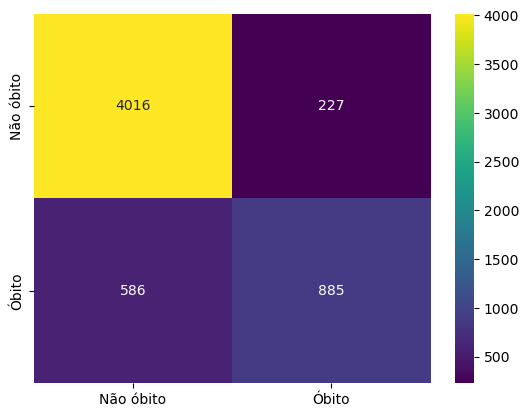

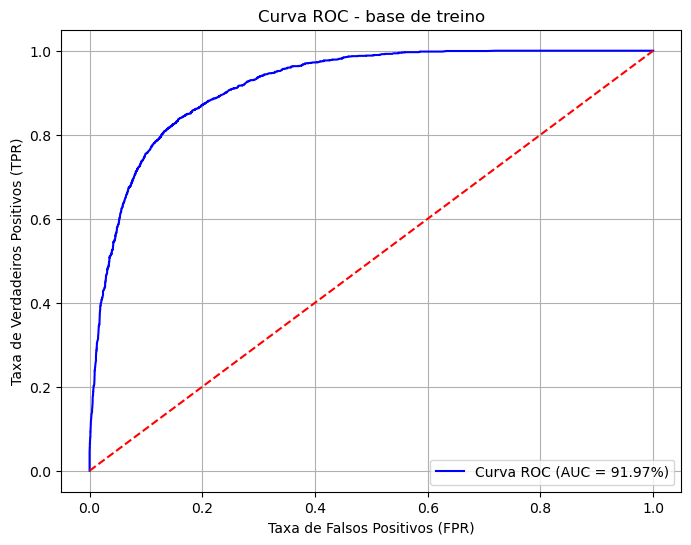

************************************************************
BASE TESTE


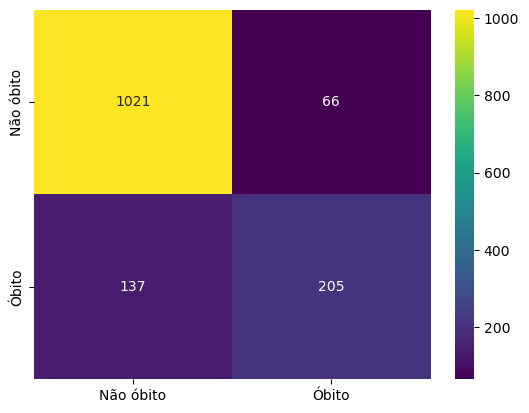

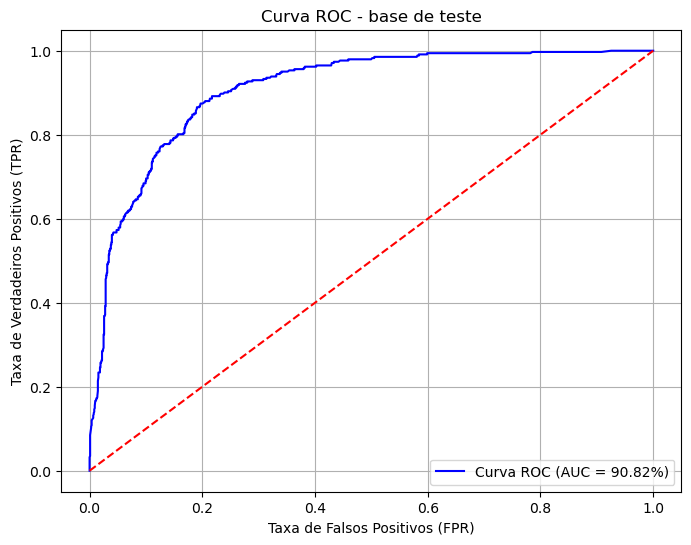

************************************************************


,RandomForestClassifier,Acuracia,Acuracia Balanceada,Precisão,Recall,Especificidade,F1-Score,AUC
0,Base de treino,0.857718,0.774066,0.795863,0.601632,0.946500,0.685250,0.919656
1,Base de teste,0.857943,0.769349,0.756458,0.599415,0.939282,0.668842,0.908250


In [41]:
avalia_treino_teste(melhor_modelo_rfc, X_treino, X_teste, y_treino, y_teste)

XGB Classifier

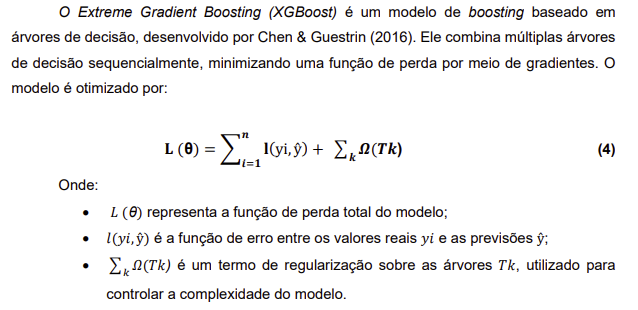

In [42]:
modelo_ajustado_xgb = XGBClassifier(eval_metric='logloss') #XGBoost

#define hyperparameters 

param_grid_xgb = {
            'max_depth': [2, 4, 6, 8, 10],
            'learning_rate': [0.01, 0.1, 0.2],
            'n_estimators': [50, 100, 200],
            'subsample': [0.8, 1.0],
            'colsample_bytree': [0.8, 1.0],
            'random_state': [42]
}

#Create a GridSearchCV object

grid_search_xgb = GridSearchCV(
    modelo_ajustado_xgb,
    param_grid = param_grid_xgb,      
    cv = 5,
    scoring = 'roc_auc',
    verbose=1,
    n_jobs=-1).fit(X_treino, y_treino.values.ravel())

print(grid_search_xgb.best_params_)

melhor_modelo_xgb = grid_search_xgb.best_estimator_

Fitting 5 folds for each of 180 candidates, totalling 900 fits
{'colsample_bytree': 1.0, 'learning_rate': 0.2, 'max_depth': 2, 'n_estimators': 50, 'random_state': 42, 'subsample': 0.8}


BASE TREINO


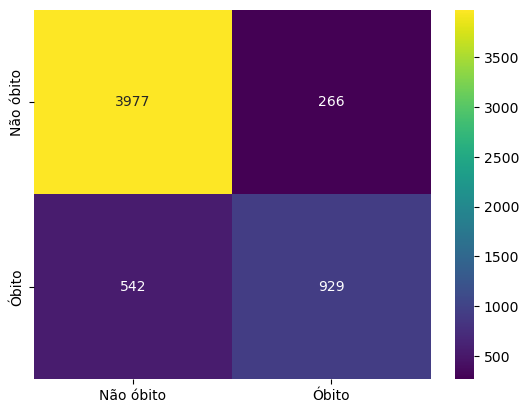

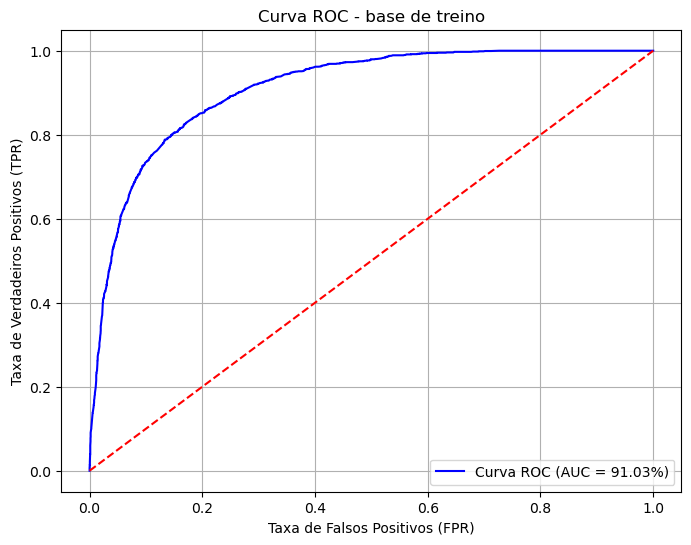

************************************************************
BASE TESTE


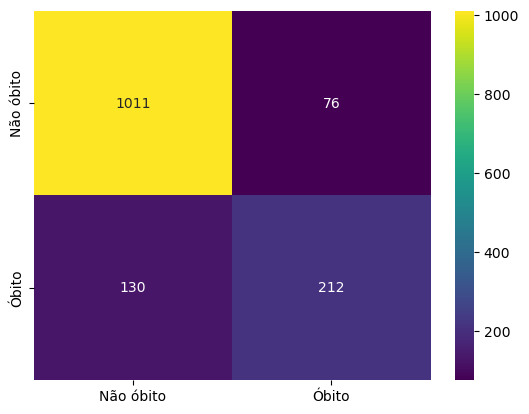

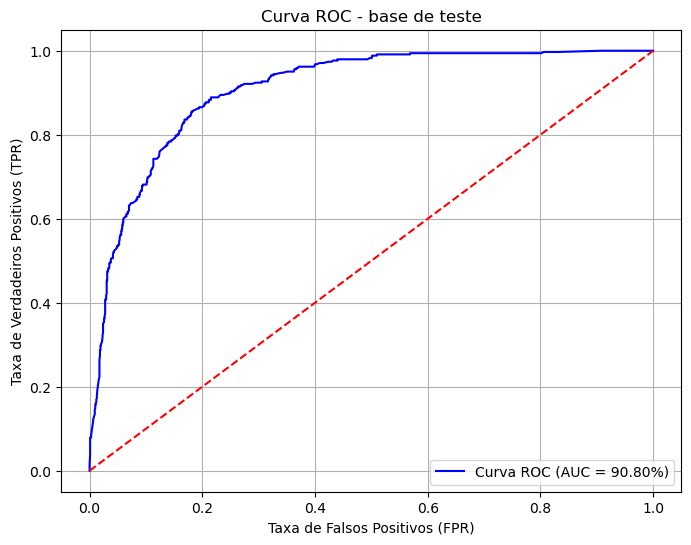

************************************************************


,XGBClassifier,Acuracia,Acuracia Balanceada,Precisão,Recall,Especificidade,F1-Score,AUC
0,Base de treino,0.858593,0.784426,0.777406,0.631543,0.937309,0.696924,0.910258
1,Base de teste,0.855843,0.774983,0.736111,0.619883,0.930083,0.673016,0.907981


In [43]:
avalia_treino_teste(melhor_modelo_xgb, X_treino, X_teste, y_treino, y_teste)

LGBM Classifier

O Light Gradient Boosting Machine (“LightGBM”) é um modelo baseado em boosting
que utiliza a técnica de Gradient-Based One-Side Sampling (GOSS) para reduzir o número
de instâncias analisadas em cada iteração, tornando-o mais eficiente em grandes volumes de
dados (Ke et al., 2017). Sua função de perda é similar à do XGBoost, mas sua abordagem
baseada em histogramas torna o treinamento mais rápido e eficiente.

In [44]:
modelo_ajustado_lgbm = LGBMClassifier() #LightGBM

#define hyperparameters 

param_grid_lgbm = {
            'max_depth': [2, 4, 6, 8, 10],
            'learning_rate': [0.01, 0.1, 0.2],
            'n_estimators': [50, 100, 200],
            'subsample': [0.8, 1.0],
            'colsample_bytree': [0.8, 1.0],
            'random_state': [42]
}

#Create a GridSearchCV object

grid_search_lgbm = GridSearchCV(
    modelo_ajustado_lgbm,
    param_grid = param_grid_lgbm,      
    cv = 5,
    scoring = 'roc_auc',
    verbose=1,
    n_jobs=-1).fit(X_treino, y_treino.values.ravel())

print(grid_search_lgbm.best_params_)

melhor_modelo_lgbm = grid_search_lgbm.best_estimator_

Fitting 5 folds for each of 180 candidates, totalling 900 fits
[LightGBM] [Info] Number of positive: 1471, number of negative: 4243
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000286 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 128
[LightGBM] [Info] Number of data points in the train set: 5714, number of used features: 12
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.257438 -> initscore=-1.059328
[LightGBM] [Info] Start training from score -1.059328
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGB

BASE TREINO


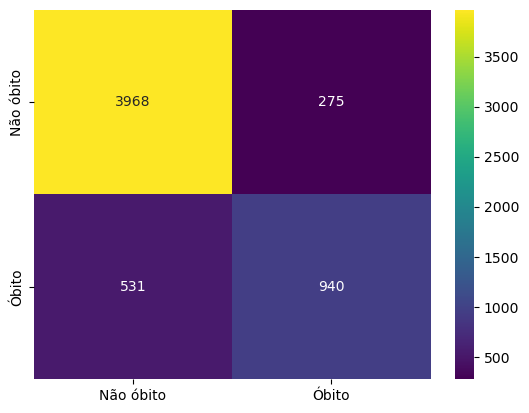

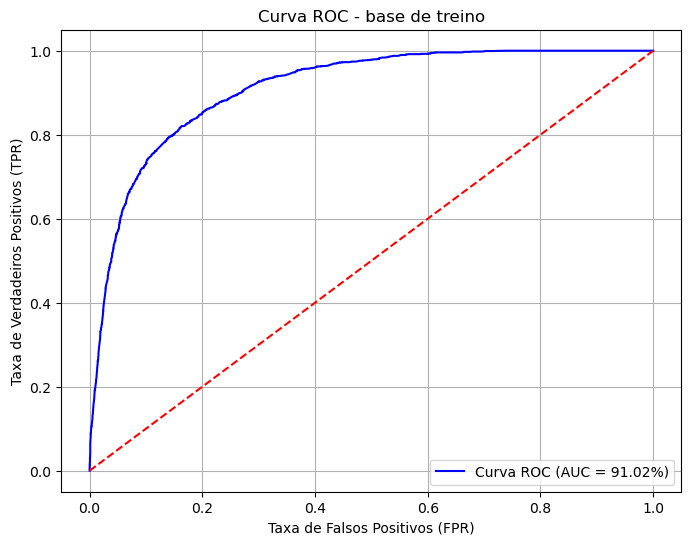

************************************************************
BASE TESTE


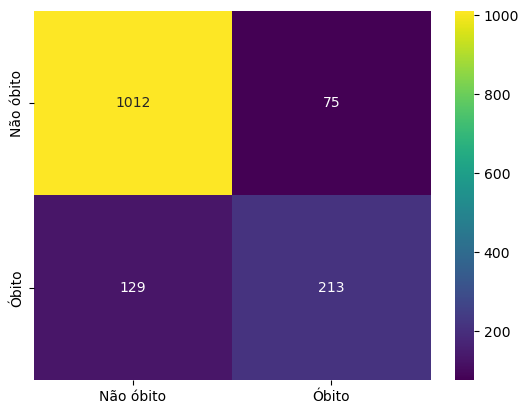

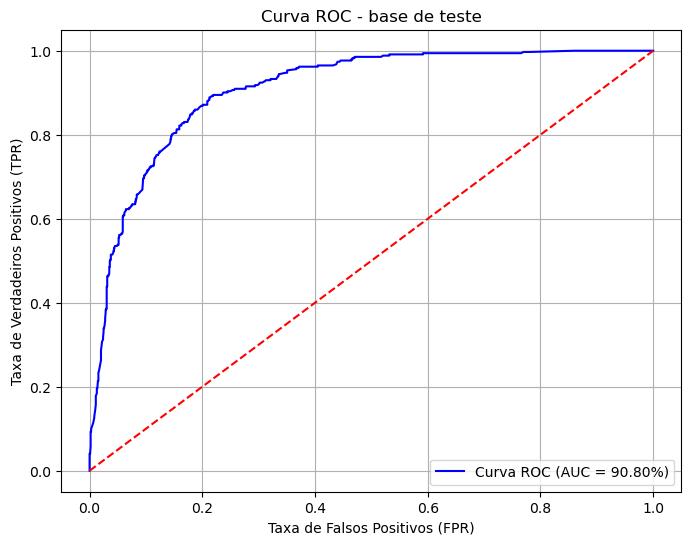

************************************************************


,LGBMClassifier,Acuracia,Acuracia Balanceada,Precisão,Recall,Especificidade,F1-Score,AUC
0,Base de treino,0.858943,0.787104,0.773663,0.639021,0.935187,0.699926,0.910234
1,Base de teste,0.857243,0.776905,0.739583,0.622807,0.931003,0.676190,0.907978


In [45]:
avalia_treino_teste(melhor_modelo_lgbm, X_treino, X_teste, y_treino, y_teste)

In [46]:
best_models = [melhor_modelo_dtc, melhor_modelo_rfc, melhor_modelo_xgb, melhor_modelo_lgbm]

def metricas_melhores_modelos(clf, X_te = X_teste, y_te = y_teste):

    # Calcular as classificações preditas
    pred_te = clf.predict(X_te)

    # Calcular a probabilidade de evento
    y_prob_te = clf.predict_proba(X_te)[:, -1]

    # Calculando acurácia e matriz de confusão
    cm_te = confusion_matrix(y_te, pred_te)
    vn_te, fp_te, fn_te, vp_te = cm_te.ravel()
    ac_te = accuracy_score(y_te, pred_te)
    bac_te = balanced_accuracy_score(y_te, pred_te)
    precisao_te = precision_score(y_te, pred_te)
    recall_te = recall_score(y_te, pred_te)
    f1_te = f1_score(y_te, pred_te)
    especificidade_te = vn_te / (vn_te + fp_te)

    # Calculando AUC
    auc_score_te = roc_auc_score(y_te, y_prob_te)

    clf_class = clf.__class__.__name__    

    data_teste = {
    #f"{clf_class}": ["Base de teste"],
    "Modelos": [f"{clf_class}"],
    "Acuracia": [ac_te],
    "Acuracia Balanceada": [bac_te],
    "Precisão": [precisao_te],
    "Recall": [recall_te],
    "Especificidade": [especificidade_te],
    "F1-Score": [f1_te],
    "AUC": [auc_score_te]
    }
    df_teste = pd.DataFrame(data_teste)

    return df_teste

In [47]:
lista_melhores_teste = []

for clf in best_models:    
    lista_melhores_teste.append(metricas_melhores_modelos(clf))
    
df_melhores_teste = pd.concat(lista_melhores_teste, ignore_index=True)

#df_melhores_teste = pd.DataFrame(df_melhores_teste)

metricas_finais = pd.concat([df_resultado_logit, df_melhores_teste], ignore_index=True)

display(metricas_finais)

,Modelos,Acuracia,Acuracia Balanceada,Precisão,Recall,Especificidade,F1-Score,AUC
0,Logit,0.850903,0.772892,0.752703,0.614451,0.931332,0.676587,0.903017
1,DecisionTreeClassifier,0.853744,0.773603,0.728522,0.619883,0.927323,0.669826,0.897639
2,RandomForestClassifier,0.857943,0.769349,0.756458,0.599415,0.939282,0.668842,0.908250
3,XGBClassifier,0.855843,0.774983,0.736111,0.619883,0.930083,0.673016,0.907981
4,LGBMClassifier,0.857243,0.776905,0.739583,0.622807,0.931003,0.676190,0.907978


                                   features  importance
0                                IDADE_AJUS         107
7                       SUPORT_VEN_INVASIVO          46
6                                   UTI_SIM          24
5                             DESC_RESP_SIM          21
10                           FATOR_RISC_SIM          18
1                        CS_RACA_BRANCA_SIM          14
4                                 TOSSE_SIM          14
3                            NOSOCOMIAL_SIM          13
9   CLASSI_FIN_SRAG_OUTRO_AGENTE_ETIOLOGICO          12
8                   SUPORT_VEN_NAO_INVASIVO          11
2                              DIARREIA_SIM          10
11                           VACINA_COV_SIM          10


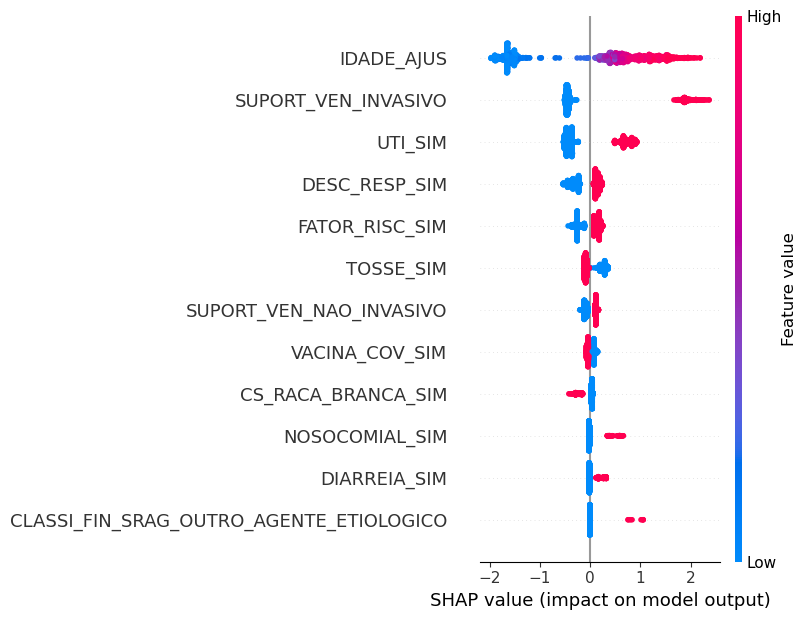

In [48]:
# #%% Calcular os 'shap values'

#amostra = X_teste.sample(frac=0.1) #apenas 10% das amostras x

amostra = X_teste 

explainer = shap.TreeExplainer(melhor_modelo_lgbm)
shap_values = explainer.shap_values(amostra)

#%% Importância das variáveis preditoras

rf_features = pd.DataFrame({'features':X.columns.tolist(),
                            'importance':melhor_modelo_lgbm.feature_importances_})

rf_features = rf_features.sort_values(by= 'importance', ascending= False)

print(rf_features)

#%% Gráfico Resumo
shap.summary_plot(shap_values, amostra, feature_names=X.columns)

# Rede Neural

In [49]:
# Definir a seed para reprodutibilidade
seed = 0
np.random.seed(seed)
tf.random.set_seed(seed)
random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed) #ambiente de execução do python

initializer = tf.keras.initializers.GlorotUniform(seed=seed) #inicialização de pesos

tf.config.experimental.enable_op_determinism() #o tensor flow funcione de forma dterministica e não aleatória

In [50]:
# # Normalizar os dados
scaler = MinMaxScaler()

df_sivep_dummies['IDADE_NORM'] = scaler.fit_transform(df_sivep_dummies[['IDADE_AJUS']])

# # Normalizar (PADRONIZAR) os dados z-score
# mean = df_sivep_dummies['IDADE_AJUS'].mean(axis=0)
# std = df_sivep_dummies['IDADE_AJUS'].std(axis=0)
# norm_man = (df_sivep_dummies['IDADE_AJUS'] - mean) / std
# df_sivep_dummies['IDADE_AJUS'] = norm_man

y_r = df_sivep_dummies['EVOLUCAO']

X_r = df_sivep_dummies.drop(columns = ['EVOLUCAO', 'phat', 'IDADE_AJUS'])

X_treino_r, X_teste_r, y_treino_r, y_teste_r = train_test_split(X_r, y_r, test_size = 0.2, random_state = 42)

In [51]:
model = models.Sequential([
    layers.Dense(64, activation='relu', kernel_regularizer=l2(0.01), input_shape=(X_treino.shape[1],)),
    layers.Dropout(0.3),
    layers.Dense(32, activation='tanh', kernel_regularizer=l2(0.01)),
    layers.Dropout(0.2),
    layers.Dense(16, activation='relu', kernel_regularizer=l2(0.01)),
    layers.Dropout(0.1),
    layers.Dense(1, activation='sigmoid')
])

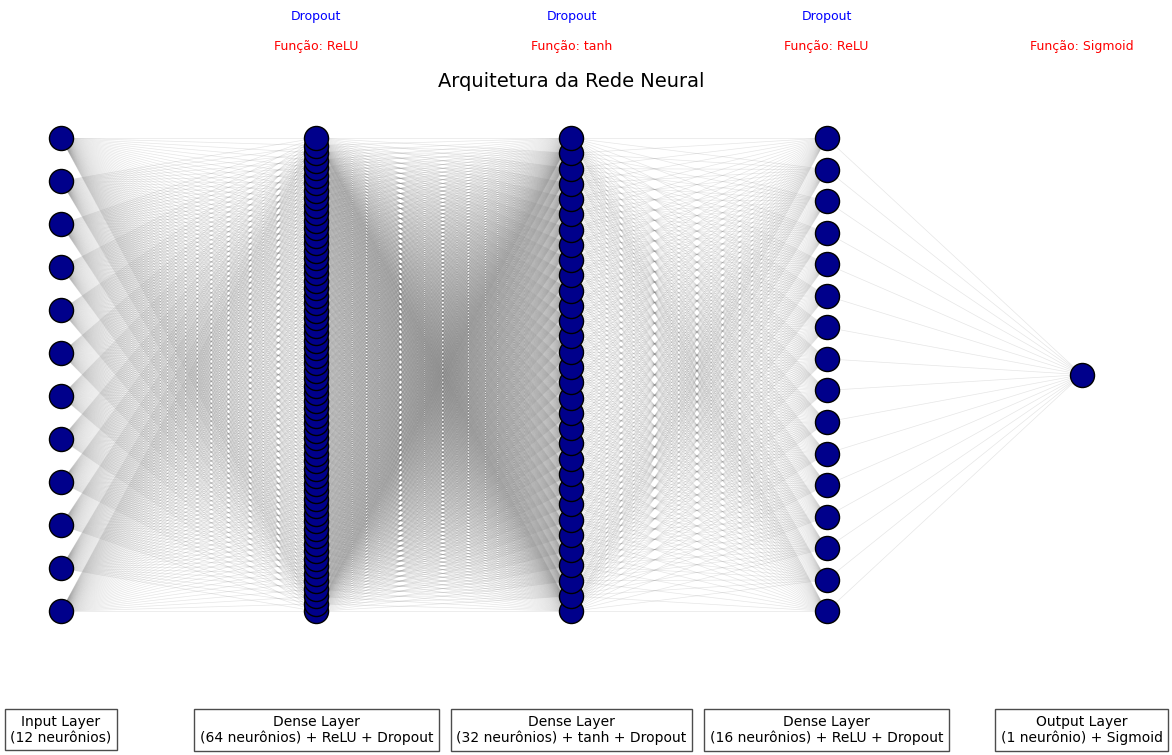

In [25]:
import matplotlib.pyplot as plt
import numpy as np

def desenhar_neuronios(x, num_neuronios, cor='darkblue'):
    if num_neuronios == 1:
        y_positions = [0.5]  # Centraliza o único neurônio
    else:
        y_positions = np.linspace(0.1, 0.9, num_neuronios)
    for y in y_positions:
        plt.scatter(x, y, s=300, color=cor, edgecolor='black', zorder=4)
    return y_positions

def desenhar_textos(x, label, activation=None, dropout=False):
    plt.text(x, -0.1, label, ha='center', va='center', fontsize=10,
             bbox=dict(facecolor='white', alpha=0.7))
    if activation:
        plt.text(x, 1.05, f"Função: {activation}", ha='center', fontsize=9, color='red')
    if dropout:
        plt.text(x, 1.1, "Dropout", ha='center', fontsize=9, color='blue')

def conectar_camadas(x1, y1_list, x2, y2_list):
    for y1 in y1_list:
        for y2 in y2_list:
            plt.plot([x1, x2], [y1, y2], color='gray', alpha=0.2, lw=0.5)

def desenhar_rede(layers):
    plt.figure(figsize=(12, 8))
    plt.title("Arquitetura da Rede Neural", fontsize=14, pad=20)
    plt.axis('off')

    x_positions = np.linspace(0.1, 0.9, len(layers))
    neuronios_posicoes = []

    for i, layer in enumerate(layers):
        x = x_positions[i]
        y_list = desenhar_neuronios(x, layer["neurons"])
        neuronios_posicoes.append((x, y_list))
        desenhar_textos(x, layer["label"], layer.get("activation"), layer.get("dropout"))

    for i in range(len(neuronios_posicoes) - 1):
        x1, y1_list = neuronios_posicoes[i]
        x2, y2_list = neuronios_posicoes[i + 1]
        conectar_camadas(x1, y1_list, x2, y2_list)

    plt.tight_layout()
    plt.savefig("rede_neural.png", dpi=300, bbox_inches='tight')
    plt.show()

# Definição da arquitetura
camadas = [
    {"label": "Input Layer\n(12 neurônios)", "neurons": 12},
    {"label": "Dense Layer\n(64 neurônios) + ReLU + Dropout", "neurons": 64, "activation": "ReLU", "dropout": True},
    {"label": "Dense Layer\n(32 neurônios) + tanh + Dropout", "neurons": 32, "activation": "tanh", "dropout": True},
    {"label": "Dense Layer\n(16 neurônios) + ReLU + Dropout", "neurons": 16, "activation": "ReLU", "dropout": True},
    {"label": "Output Layer\n(1 neurônio) + Sigmoid", "neurons": 1, "activation": "Sigmoid"}
]

# Chamada principal
desenhar_rede(camadas)

In [52]:
optimizer = Adam(learning_rate=0.0001)  # Teste valores menores (0.0005, 0.0001)
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

In [53]:
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
#o modelo vai parar automaticamente quando perceber que val_loss está aumentando por muitas épocas seguidas

history = model.fit(X_treino_r, y_treino_r, epochs=1000, batch_size=20,
                     validation_split=0.2, callbacks=[early_stopping])

Epoch 1/1000
229/229 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.6461 - loss: 1.4459 - val_accuracy: 0.7428 - val_loss: 1.2620
Epoch 2/1000
229/229 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7537 - loss: 1.2363 - val_accuracy: 0.7664 - val_loss: 1.1115
Epoch 3/1000
229/229 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7743 - loss: 1.1022 - val_accuracy: 0.7822 - val_loss: 0.9933
Epoch 4/1000
229/229 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8023 - loss: 0.9873 - val_accuracy: 0.8250 - val_loss: 0.8961
Epoch 5/1000
229/229 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8220 - loss: 0.9018 - val_accuracy: 0.8381 - val_loss: 0.8190
Epoch 6/1000
229/229 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8290 - loss: 0.8271 - val_accuracy: 0.8399 - val_loss: 0.7559
Epoch 7/1000
229/229 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8282 - loss: 0.7685 - val_accuracy: 0.8408 - val_loss: 0.7035
Epoch 8/1000
229/229 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8329 - loss: 0.7216 - 

In [54]:
# Avaliar no conjunto de treino
train_loss, train_acc = model.evaluate(X_treino_r, y_treino_r, verbose=1)

# Avaliar no conjunto de teste
test_loss, test_acc = model.evaluate(X_teste_r, y_teste_r, verbose=1)

print(f'Perda no treino: {train_loss:.4f}, Acurácia no treino: {train_acc:.4f}')
print(f'Perda no teste: {test_loss:.4f}, Acurácia no teste: {test_acc:.4f}')

179/179 ━━━━━━━━━━━━━━━━━━━━ 0s 869us/step - accuracy: 0.8545 - loss: 0.3639
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 914us/step - accuracy: 0.8496 - loss: 0.3663
Perda no treino: 0.3674, Acurácia no treino: 0.8509
Perda no teste: 0.3525, Acurácia no teste: 0.8516


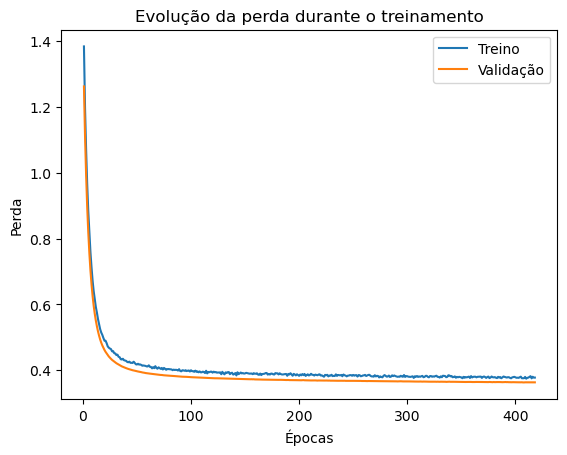

In [55]:
# Recuperar valores da perda no treino e validação
epochs = range(1, len(history.history['loss']) + 1)
plt.plot(epochs, history.history['loss'], label='Treino')
plt.plot(epochs, history.history['val_loss'], label='Validação')
plt.xlabel('Épocas')
plt.ylabel('Perda')
plt.legend()
plt.title('Evolução da perda durante o treinamento')
plt.show()

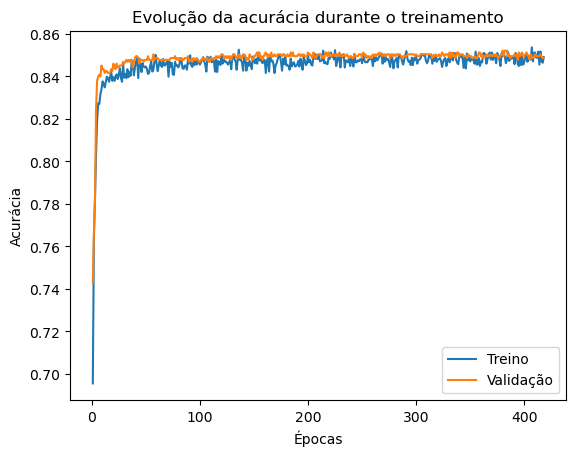

In [56]:
plt.plot(epochs, history.history['accuracy'], label='Treino')
plt.plot(epochs, history.history['val_accuracy'], label='Validação')
plt.xlabel('Épocas')
plt.ylabel('Acurácia')
plt.legend()
plt.title('Evolução da acurácia durante o treinamento')
plt.show()